**Objective:** Build a classification model that is trained on the human DNA sequence and can predict a gene family based on the DNA sequence of the coding sequence. To test the model, we will use the DNA sequence of humans, dogs, and chimpanzees and compare the accuracies.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import time

In [3]:
# size of our kmer words
k_mer = 5

#### reading and exploring the data

In [4]:
human_dna = pd.read_table('HCD_data/human.txt')
chimp_dna = pd.read_table('HCD_data/chimpanzee.txt')
dog_dna = pd.read_table('HCD_data/dog.txt')
human_dna.head(3)

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3


In [5]:
len(human_dna), len(chimp_dna), len(dog_dna)

(4380, 1682, 820)

In [6]:
def kmer_fun(seq, win_size):
    return [seq[x:x+win_size].lower() for x in range(len(seq) - win_size + 1)]


#So let’s try it out with a simple sequence:
mySeq = 'GTGCCA'
kmer_fun(mySeq, win_size=k_mer)

['gtgcc', 'tgcca']

In [7]:
# merging the three dataframes 
all_dna_data = pd.concat([human_dna, dog_dna, chimp_dna])
all_dna_data.sample(frac=1).reset_index(inplace=True, drop = True)
all_dna_data.tail()

,sequence,class
1677,ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...,5
1678,ATGCTGAGCGGAGCGGCTGGGGCTGCGCGGCGTGGCGGAGCAGCGC...,5
1679,ATGAAGCGACCCAAGGAGCCGAGCGGCTCCGACGGGGAGTCCGACG...,6
1680,ATGACTGGAACCCCAAAGACTCAAGAAGGAGCTAAAGATCTTGAAG...,3
1681,ATGTTGCCCAGCTGTGGCAAGATCTTGACTGGGTGTAAGAATATGC...,3


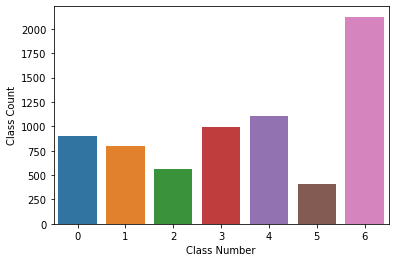

In [8]:
sns.countplot(x =all_dna_data['class'].to_numpy())
# plt.title("Class Distribution in data")
plt.xlabel('Class Number')
plt.ylabel('Class Count')
plt.savefig('class_dist.png')
plt.show()

In [9]:
all_dna_data[str(k_mer)+'-mer'] = all_dna_data.apply(
                    lambda x: kmer_fun(x['sequence'], win_size= k_mer), axis=1)
all_dna_data.head()

,sequence,class,5-mer
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,"[atgcc, tgccc, gcccc, cccca, cccaa, ccaac, caa..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,"[atgaa, tgaac, gaacg, aacga, acgaa, cgaaa, gaa..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[atgtg, tgtgt, gtgtg, tgtgg, gtggc, tggca, ggc..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,"[atgtg, tgtgt, gtgtg, tgtgg, gtggc, tggca, ggc..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,"[atgca, tgcaa, gcaac, caaca, aacag, acagc, cag..."


In [10]:
# making sentences based on the k-mers
dna_texts = list(all_dna_data[str(k_mer)+'-mer'])
for item in range(len(dna_texts)):
    dna_texts[item] = ' '.join(dna_texts[item])

print('Sample 1: ', dna_texts[0])

Sample 1:  atgcc tgccc gcccc cccca cccaa ccaac caact aacta actaa ctaaa taaat aaata aatac atact tacta actac ctacc taccg accgt ccgta cgtat gtatg tatgg atggc tggcc ggccc gccca cccac ccacc cacca accat ccata cataa ataat taatt aatta attac ttacc taccc acccc ccccc cccca cccat ccata catac atact tactc actcc ctcct tcctt cctta cttac ttaca tacac acact cacta actat ctatt tattc attcc ttcct tcctc cctca ctcat tcatc catca atcac tcacc caccc accca cccaa ccaac caact aacta actaa ctaaa taaaa aaaaa aaaat aaata aatat atatt tatta attaa ttaaa taaac aaaca aacac acaca cacaa acaaa caaac aaact aacta actac ctacc tacca accac ccacc cacct accta cctac ctacc tacct acctc cctcc ctccc tccct ccctc cctca ctcac tcacc cacca accaa ccaaa caaag aaagc aagcc agccc gccca cccat ccata cataa ataaa taaaa aaaaa aaaat aaata aataa ataaa taaaa aaaaa aaaaa aaaat aaatt aatta attat ttata tataa ataac taaca aacaa acaaa caaac aaacc aaccc accct ccctg cctga ctgag tgaga gagaa agaac gaacc aacca accaa ccaaa caaaa aaaat aaatg aatga atgaa tgaac gaacg aacga

In [11]:
# We will be creating vectors that have a dimensionality equal to the size of our vocabulary,
# and if the text data features that vocab word, we will put a one in that dimension.
cv = CountVectorizer(ngram_range=(1, 1))
X = cv.fit_transform(dna_texts)

# get the labels
y = all_dna_data['class'].values 

In [12]:
X.shape

(6882, 1303)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   random_state=42,
                                                   test_size=0.3,
                                                   stratify=all_dna_data['class'])

In [14]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [15]:
cv.vocabulary_

{'atgcc': 238,
 'tgccc': 1190,
 'gcccc': 624,
 'cccca': 352,
 'cccaa': 348,
 'ccaac': 333,
 'caact': 273,
 'aacta': 29,
 'actaa': 117,
 'ctaaa': 472,
 'taaat': 1040,
 'aaata': 13,
 'aatac': 52,
 'atact': 208,
 'tacta': 1065,
 'actac': 118,
 'ctacc': 477,
 'taccg': 1059,
 'accgt': 95,
 'ccgta': 380,
 'cgtat': 455,
 'gtatg': 750,
 'tatgg': 1095,
 'atggc': 242,
 'tggcc': 1206,
 'ggccc': 688,
 'gccca': 623,
 'cccac': 349,
 'ccacc': 337,
 'cacca': 287,
 'accat': 87,
 'ccata': 344,
 'cataa': 316,
 'ataat': 204,
 'taatt': 1052,
 'aatta': 64,
 'attac': 251,
 'ttacc': 1242,
 'taccc': 1058,
 'acccc': 89,
 'ccccc': 353,
 'cccat': 351,
 'catac': 317,
 'tactc': 1066,
 'actcc': 122,
 'ctcct': 495,
 'tcctt': 1135,
 'cctta': 398,
 'cttac': 523,
 'ttaca': 1241,
 'tacac': 1054,
 'acact': 75,
 'cacta': 296,
 'actat': 120,
 'ctatt': 487,
 'tattc': 1098,
 'attcc': 255,
 'ttcct': 1260,
 'tcctc': 1133,
 'cctca': 389,
 'ctcat': 491,
 'tcatc': 1116,
 'catca': 320,
 'atcac': 218,
 'tcacc': 1107,
 'caccc': 288,


### Helper funtions

In [16]:
# the funciton will draw a heat map
def make_heat_map(model, title= 'Heat map'):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cm, figsize=(4,4), hide_ticks=True,cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(range(7), ['1','2','3','4','5','6','7'], fontsize=12)
    plt.yticks(range(7), ['1','2','3','4','5','6','7'], fontsize=12)
    plt.show()

In [17]:
def train_model(model, model_name = ''):
    s = time.time()
    model.fit(X_train, y_train)
    e = time.time()
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    f1_train = f1_score(y_train, preds_train, average = 'macro')
    f1_test = f1_score(y_test, preds_test, average = 'macro')
    print('{} produced train F1 score of {:.3f}'.format(model_name, f1_train))
    print('{} produced test F1 score of {:.3f}'.format(model_name, f1_test))
    print('Time took to train {:.3f} seconds'.format(e-s))
    make_heat_map(model, model_name)

### Models

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

##### Logistic regression

A:\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression produced train F1 score of 0.997
Logistic regression produced test F1 score of 0.905
Time took to train 5.362 seconds


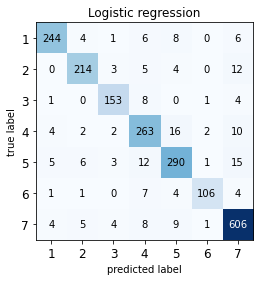

In [22]:
logReg = LogisticRegression(C = .1, random_state=0, max_iter = 500)
train_model(logReg, 'Logistic regression')

A:\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression produced train F1 score of 1.000
Logistic regression produced test F1 score of 0.893
Time took to train 5.775 seconds


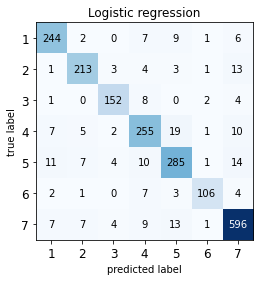

In [23]:
logReg = LogisticRegression(C = 1, random_state=0, max_iter = 500)
train_model(logReg, 'Logistic regression')

A:\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression produced train F1 score of 1.000
Logistic regression produced test F1 score of 0.884
Time took to train 5.768 seconds


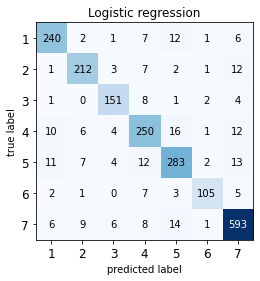

In [24]:
logReg = LogisticRegression(C = 10, random_state=0, max_iter = 500)
train_model(logReg, 'Logistic regression')

##### Random Forests

Random Forests 50 estimators produced train F1 score of 1.000
Random Forests 50 estimators produced test F1 score of 0.854
Time took to train 0.649 seconds


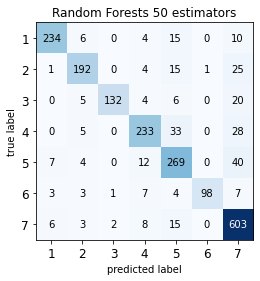

In [21]:
rf = RandomForestClassifier(n_estimators = 50)
train_model(rf, 'Random Forests 50 estimators')

Random Forests 100 estimators produced train F1 score of 1.000
Random Forests 100 estimators produced test F1 score of 0.856
Time took to train 1.318 seconds


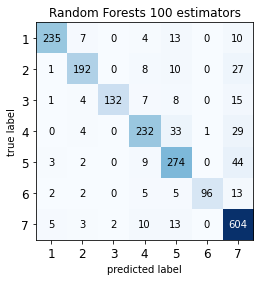

In [20]:
rf = RandomForestClassifier(n_estimators = 100)
train_model(rf, 'Random Forests 100 estimators')

Random Forests 200 estimators produced train F1 score of 1.000
Random Forests 200 estimators produced test F1 score of 0.859
Time took to train 2.673 seconds


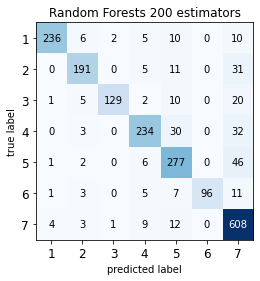

In [22]:
rf = RandomForestClassifier(n_estimators = 200)
train_model(rf, 'Random Forests 200 estimators')

##### SVM

SVM produced train F1 score of 0.575
SVM produced test F1 score of 0.600
Time took to train 1.693 seconds


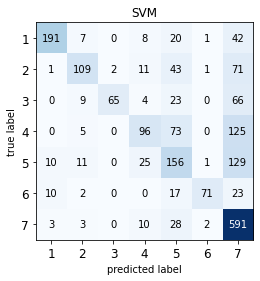

In [23]:
svm = SVC(kernel='rbf', gamma= 'scale', C = 1)
train_model(svm, 'SVM')

SVM produced train F1 score of 0.745
SVM produced test F1 score of 0.732
Time took to train 1.354 seconds


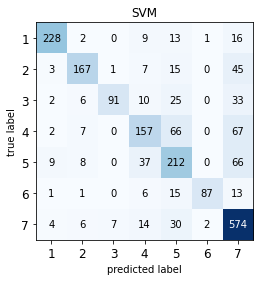

In [24]:
svm = SVC(kernel='rbf', gamma= 'scale', C = 10)
train_model(svm, 'SVM')

SVM produced train F1 score of 0.815
SVM produced test F1 score of 0.773
Time took to train 1.357 seconds


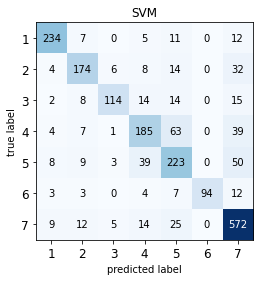

In [25]:
svm = SVC(kernel='rbf', gamma= 'scale', C = 50)
train_model(svm, 'SVM')

##### Naive Bayes

Gaussian Navie Bayes produced train F1 score of 0.134
Gaussian Navie Bayes produced test F1 score of 0.120
Time took to train 0.007 seconds


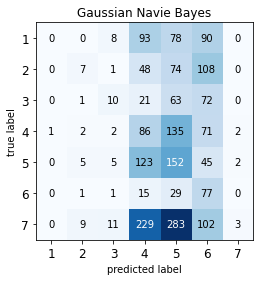

In [26]:
gnb = GaussianNB()
train_model(gnb, 'Gaussian Navie Bayes')